In [1]:
import numpy as np
from scipy.optimize import root_scalar
from scipy.optimize import brentq
import matplotlib.pyplot as plt

# Functions

In [76]:
#parameters
t = 0.425
e=1.602*10**(-19)
kB = 8.617e-5
T=0.1
beta=1/(kB*T)

A_0=0.1
Theta=0


# k-grid
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

In [18]:
#dispersion

def epsilon(t,kx,ky,mu):
    return -2*t*(np.cos(kx)+np.cos(ky))-mu

def Ek(t,kx,ky,mu,delta):
    return np.sqrt(epsilon(t,kx,ky,mu)**2+delta**2*formfactor(kx,ky)**2)

def formfactor(kx,ky):
    return 1/2*(np.cos(kx)-np.cos(ky))

def n(t,mu,delta):
    return 1/n_k *np.sum(1-epsilon(t,KX,KY,mu)/Ek(t,KX,KY,mu,delta)*np.tanh(beta/2*Ek(t,KX,KY,mu,delta)))

def density_difference(mu,n0,t,delta):
    return n(t,mu,delta)-n0

In [59]:
def sigmax_0(kx,ky,mu,delta):
    return delta*formfactor(kx,ky)/(2*Ek(t,kx,ky,mu,delta))*np.tanh(beta/2*Ek(t,KX,KY,mu,delta))

def sigmaz_0(kx,ky,mu,delta):
    return -epsilon(t,kx,ky,mu)/(2*Ek(t,kx,ky,mu,delta))*np.tanh(beta/2*Ek(t,KX,KY,mu,delta))

def delta_0(mu,V,delta):
    return V/n_k*np.sum(formfactor(KX,KY)*sigmax_0(KX,KY,mu,delta))

In [13]:
def deltaDelta(V,x,y):
    return V/n_k*np.sum(formfactor(KX,KY)*(x-y))

def Dk(kx,ky,Theta):
    return np.cos(Theta)**2*2*t*np.cos(kx)+np.sin(Theta)**2*2*t*np.cos(kx)

def emodA(kx,ky,Theta,A_0):
    return e**2*A_0**2*Dk(kx,ky,Theta)

# Self consistent calculation

In [41]:
n0=1
delta0=0
V=1

try:
    mu_0 = brentq(density_difference, -10, 10, args=(n0,t,delta0), xtol=1e-5)
except ValueError:
    print("mu not found")

print("mu_0=",mu_0)
mu_current = mu_0

delta_current=1



for i in range(1000):
    # Compute updated order parameters
    delta_new=delta_0(mu_current,V,delta_current)

    # Update mu to maintain total density ~1
    try:
        mu_new = brentq(density_difference, -100, 100, args=(n0,t,delta_new), xtol=1e-5)
    except ValueError:
        print("mu not found")
        break

    # Check total density
    n_new=n(t,mu_new,delta_new)

    print(f"step {i+1}: delta = {delta_new:.3f}, μ = {mu_new:.3f}, n = {n_new:.3f}")

    # Check convergence
    if (np.abs(delta_new-delta_current)+np.abs(n_new - n0)) < 1e-5:
        print(f"✅ Converged in {i+1} steps.")
        break

    # Update for next step
    delta_current=delta_new
    mu_current = mu_new

print("\n📌 Final self-consistent results:")
print(f"delta = {delta_current:.6f}")
print(f"μ   = {mu_current:.6f}")
print(f"n   = {n(t,mu_current,delta_current):.6f}")

mu_0= -1.6830261668269308
step 1: delta = 11.037, μ = -47.412, n = 1.000
step 2: delta = 4.328, μ = -18.600, n = 1.000
step 3: delta = 4.327, μ = -18.596, n = 1.000
step 4: delta = 4.327, μ = -18.596, n = 1.000
✅ Converged in 4 steps.

📌 Final self-consistent results:
delta = 4.326964
μ   = -18.596190
n   = 1.000000


# RK4

In [72]:
#pseudomagentic field

def b_x(k_x,k_y,V,delta,deltaDelta):
    return -2*(delta+np.real(deltaDelta))*formfactor(kx,ky)

def b_y(k_x,k_y,V,deltaDelta):
    return 2*np.imag(deltaDelta)*formfactor(kx,ky)

def b_z(t,k_x,k_y,mu,Theta,A_0):
    return 2*epsilon(t,kx,ky,mu)+emodA(kx,ky,Theta,A_0)

def b_vec(t,mu,V,delta,deltaDelta):
    return np.array([b_x(KX,KY,V,delta,deltaDelta),b_y(KX,KY,V,deltaDelta),b_z(t,KX,KY,mu,Theta,A_0)])

def b_length(t,mu,V,delta,x,y):
    return np.linalg.norm(b_vec(t,mu,V,delta,deltaDelta))

In [83]:
#initial state
def S0_vec(mu,delta):
    Z = np.zeros_like(KX)
    return np.array([sigmax_0(KX,KY,mu,delta),Z,sigmaz_0(KX,KY,mu,delta)])

#delta from S
def deltafromS(S):
    return V/n_k*np.sum(formfactor(KX,KY)*(S[0]-S[1]*1j))

In [86]:
#RK4 step
hbar=1
def F(t,mu,V,delta,deltaDelta,S_vec):
    return 1/hbar*np.cross(b_vec(t,mu,V,delta,deltaDelta),S_vec,axis=0)


def rk4_step(S, mu, delta, deltaDelta, dt):

    k1= F(t,mu,V,delta,deltaDelta,S)
    delta1=deltafromS(S+dt/2*k1)
    deltaDelta1=delta-delta1

    k2= F(t,mu,V,delta1,deltaDelta1,S+dt/2*k1)
    delta2=deltafromS(S+dt/2*k1)
    deltaDelta2=delta1-delta2

    k3= F(t,mu,V,delta2,deltaDelta2,S+dt/2*k2)
    delta3=deltafromS(S+dt/2*k2)
    deltaDelta3=delta2-delta3

    k4= F(t,mu,V,delta3,deltaDelta3,S+dt*k3)

    S_new = S + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    
    return S_new, deltaDelta3

def normalize_S(S):
    norm = np.linalg.norm(S, axis=0)
    return S / (norm + 1e-12)

def enforce_spin_length(S):
    length = np.linalg.norm(S, axis=0)
    return S / np.maximum(length, 1e-12)

In [80]:
#parameters
delta0 = 4.326964
mu0   = -18.596190

In [107]:
#initial S
S_cur=S0_vec(mu0,delta0)

dt = 0.1
t_max = 100
n_steps = int(t_max/dt)


delta_t = np.zeros(n_steps+1)
deltaDelta_t = np.zeros(n_steps+1)

delta_t[0] = delta0
deltaDelta_t[0] = 0

for n in range(n_steps):
    S_cur,deltaDelta3=rk4_step(S_cur,mu0,delta_t[n],deltaDelta_t[n],dt)
    S_cur=normalize_S(S_cur)
    S_cur=enforce_spin_length(S_cur)
    delta_t[n+1]=deltafromS(S_cur)
    deltaDelta_t[n+1]=deltaDelta3

C:\Users\Marnin\AppData\Local\Temp\ipykernel_32580\1599733970.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  delta_t[n+1]=deltafromS(S_cur)
C:\Users\Marnin\AppData\Local\Temp\ipykernel_32580\1599733970.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  deltaDelta_t[n+1]=deltaDelta3


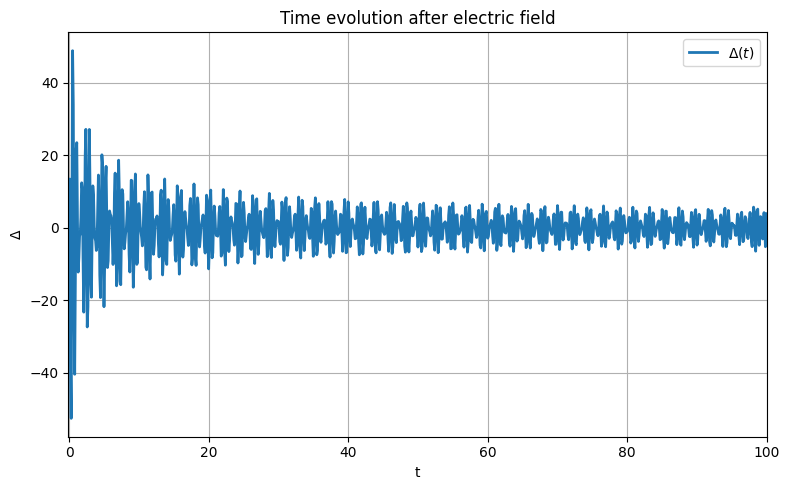

In [110]:
time = np.linspace(0, t_max, n_steps + 1)

plt.figure(figsize=(8, 5))

plt.plot(time, delta_t, label=r"$\Delta(t)$", linewidth=2)

plt.xlabel("t")

plt.ylabel(r"$\Delta$")
plt.title("Time evolution after electric field")
plt.xlim(-0.1,t_max)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('BCS time evo.png')
plt.show()